In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd

np.random.seed(123)

# Turn off progress printing 
solvers.options['show_progress'] = False

In [67]:
## NUMBER OF ASSETS
n_assets = 4

## NUMBER OF OBSERVATIONS
n_obs = 1000

return_vec_temp = np.random.randn(n_assets, n_obs)

In [87]:
return_vec = return_vec_temp.copy()
return_vec[0] = return_vec_temp[0].copy()+0
return_vec[1] = return_vec_temp[1].copy()+0
return_vec[2] = return_vec_temp[2].copy()+3
return_vec[3] = return_vec_temp[3].copy()+3

In [88]:
return_vec.shape

(4, 1000)

In [100]:
return_vec[:][:10]

array([[-0.38445002,  0.6622024 , -1.95014811, ...,  0.48741141,
         1.78785022,  1.11363008],
       [ 1.34437128,  0.57807963,  1.43193222, ..., -0.8508755 ,
         0.79236313, -0.89617306],
       [ 3.4182694 ,  4.32469309,  1.86910806, ...,  3.05275422,
         3.90685858,  2.64396194],
       [ 2.35667405,  3.6422927 ,  4.76885663, ...,  1.82251734,
         2.74676858,  2.36745069]])

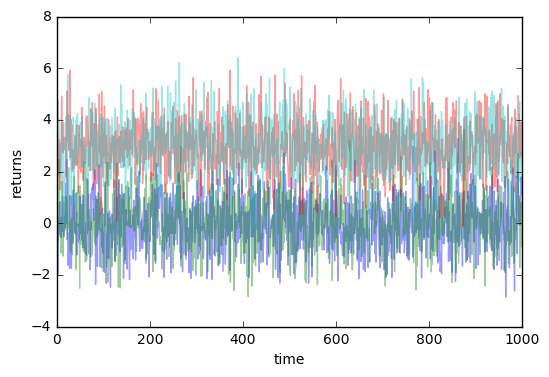

In [89]:
plt.plot(return_vec.T, alpha=.4);
plt.xlabel('time')
plt.ylabel('returns')

In [90]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

print (rand_weights(n_assets))
print (rand_weights(n_assets))

[ 0.2545459   0.1116687   0.42222869  0.21155671]
[ 0.23219177  0.28812251  0.15288826  0.32679746]


In [91]:
def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

In [92]:
rand_weights(return_vec.shape[0])

array([ 0.23893812,  0.15250331,  0.31091208,  0.29764649])

In [93]:
def portfolio(returns, weights):
    ''' 
    Returns the mean and standard deviation of returns for a portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(weights)
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    return mu, sigma

In [94]:
portfolio(return_vec, weights.T[0])

(matrix([[ 2.98412789]]), matrix([[ 0.71159247]]))

In [95]:
weights.T[0]

array([  5.97004816e-08,   1.20395748e-07,   5.20702368e-01,
         4.79297452e-01])

In [96]:
n_portfolios = 5000
means, stds = np.column_stack([random_portfolio(return_vec) for _ in  iter(range(n_portfolios))])

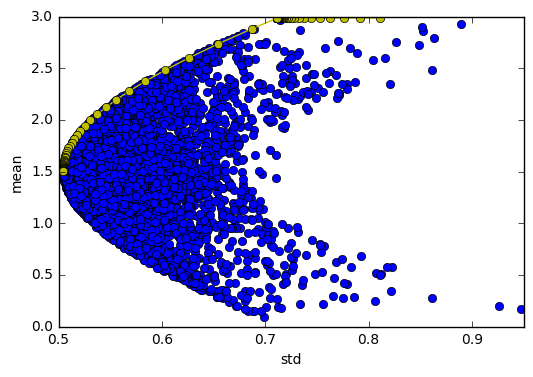

In [97]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 200
    mus = [100**(5.0 * t/N - 1.0) for t in range(N)]
    #print ('mus', mus)
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks, m1, portfolios

weights, returns, risks, polynom, portfolios = optimal_portfolio(return_vec)

plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')

In [98]:
idmax = pd.Series(np.array(returns)/ np.array(risks)).idxmax()
print ('number: ', idmax, 'return: ', returns[idmax], 'risks; ', risks[idmax])
print (np.array(portfolios[pd.Series(np.array(returns)/ np.array(risks)).idxmax()]))

number:  56 return:  2.8829290621905157 risks;  0.687429451937
[[ 0.00107867]
 [ 0.03302827]
 [ 0.50368301]
 [ 0.46221005]]
